In [ ]:
import multiprocessing as mp
import os
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_warmup as warmup
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from focal_loss.focal_loss import FocalLoss
from fortuna.conformal import AdaptivePredictionConformalClassifier
from fortuna.output_calib_model import OutputCalibClassifier
from fortuna.output_calib_model.config.base import Config
from fortuna.output_calib_model.config.optimizer import Optimizer
from kneed import KneeLocator
from pyod.models import (
    iforest,
    inne,
    lof,
    ocsvm,
)
from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
)
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import class_weight
from torch.utils.data import (
    DataLoader,
    Dataset,
)
from tqdm import tqdm

from mpproject.src.data.utils import (
    df_replace_outliers_total,
    df_resample_total,
)

pip install -r requirements.txt

In [1]:
SEED = 42


def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(SEED)

# Подготовка данных 

In [2]:
df = pd.read_csv("..\data\initial_data\data.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df

,object_id,datetime,x,y,velocity,target
0,1,2020-08-16 16:41:18,49.003344,39.545739,26.62,0
1,1,2020-08-16 16:42:18,47.250185,38.153803,27.05,1
2,1,2020-08-16 16:42:18,49.812873,37.620404,0.36,0
3,1,2020-08-16 16:45:18,47.918878,37.178980,19.83,0
4,1,2020-08-16 16:46:18,48.242001,37.438634,38.30,1
...,...,...,...,...,...,...
9995,20,2020-09-20 21:48:18,41.698727,30.520955,32.08,0
9996,20,2020-09-20 21:48:18,40.373742,32.491166,24.02,0
9997,20,2020-09-20 21:50:18,41.510299,30.651935,9.87,0
9998,20,2020-09-20 21:50:18,40.650183,31.425671,2.84,0


Проблемы в данных:
* Разные временные метки
* Не все записи начинаются в одно время
* Пропущенные значения в скорости
* Аномалии в координатах

Решение:
* Resample с фиксированным временным шагом. Изначально планировалось интерполировать возникающие после этого шага отсутствующие значения. Это допустимо, если между соседними измерениями прошло мало времени. Однако моделировать движение в течении пропущенных, например, 3 дней бессмысленно.
* Алгоритм классификации основан на перемещении за последние n временных меток. То есть от времени он не зависит, а лишь от паттерна движения.
* Можно восстановить.
* Автоматизировать процесс поиска аномалий. При этом важно захватить все крайние точки, а если нормальная точка будет принята за аномалию - это не так страшно, ведь при восстановлении она окажется примерно в том же месте (паттерн сохранится)

In [3]:
def haversine(df: pd.DataFrame):
    """
    Вычисляет столбец расстояние, пройденное за промежутки времени.

    Аргументы:
    df - датафрейм.
    """
    object_shift = df["object_id"].shift(1)
    x = df["x"]
    y = df["y"]
    x_shift = x.shift(1)
    y_shift = y.shift(1)

    x = np.radians(x)
    y = np.radians(y)
    x_shift = np.radians(x_shift)
    y_shift = np.radians(y_shift)

    delt_x = x_shift - x
    delt_y = y_shift - y
    delt_x.loc[df["object_id"] != object_shift] = np.nan
    delt_y.loc[df["object_id"] != object_shift] = np.nan

    a = np.square(np.sin(delt_x / 2)) + np.cos(x) * np.cos(x_shift) * np.square(
        np.sin(delt_y / 2)
    )
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6378.137 * c  # радиус Земли
    return km


def compute_velocity(
    df: pd.DataFrame,
    column_name: str,
    insert_dist: bool = False,
    insert_dtime: bool = False,
):
    """
    Вычисляет среднюю скорость за время движения объекта.

    Аргументы:
    df - датафрейм.
    column_name - имя столбца посчитанной скорости.
    insert_dtime - вставлять ли столбец расстояний между соседями.
    insert_dtime - вставлять ли столбец прошедшего времени между соседями.
    """
    delt_time = df["datetime"].diff().apply(lambda x: x.seconds)
    delt_dist = haversine(df)
    df[column_name] = delt_dist / (delt_time / 3600) / 1.852
    if insert_dist:
        df["delt_dist"] = delt_dist
    if insert_dtime:
        df["dtime"] = delt_time
    return df

In [4]:
df.isna().sum()

object_id      0
datetime       0
x              0
y              0
velocity     943
target         0
dtype: int64

Посмотрим на временные шаги. Обращать внимание будем на столбец target - при слишком сильном усреднении (например, 1 день) может сложиться ситуация, что в нем будут одни 1.

In [5]:
df["datetime"].diff()[df["object_id"] == df["object_id"].shift(1)].describe()

count                         9980
mean     0 days 01:41:37.286573146
std      0 days 16:12:52.675972430
min                0 days 00:00:00
25%                0 days 00:00:00
50%                0 days 00:01:00
75%                0 days 00:01:00
max                6 days 18:54:00
Name: datetime, dtype: object

In [10]:
agg_d = {col: "median" for col in df.columns[df.columns != "datetime"]}
agg_d["target"] = "max"


def df_resample(args: list):
    """
    Выполняет перегруппировку датафрейма, относящегося к одному объекту.

    Аргументы:
    args = (k, freq).
    k : int - номер объекта.
    freq : str : шаг группировки (см доступные в pandas).
    """
    k, freq = args
    dfd = df[df["object_id"] == k].copy()
    dfd = (
        dfd.set_index("datetime")
        .resample(freq)
        .agg(agg_d)
        .dropna(how="all")
        .reset_index()
    )
    return dfd


# freq = "15min"
# results = process_map(
#     df_resample,
#     [(k, freq) for k in df["object_id"].unique()], max_workers=1,
# )
# df = pd.concat(results)
# df = df.sort_values(by=["object_id", "datetime"]).reset_index(drop=True)
df = df_resample_total(df, "15min")

100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


In [11]:
df.isna().sum()

datetime     0
object_id    0
x            0
y            0
velocity     0
target       0
dtype: int64

Рассмотрим разные подходы к определению аномалий:

In [14]:
k = 1
t = df[df["object_id"] == k]
t = t.set_index("datetime").sort_index()
t["dx"] = np.abs(t["x"] - t["x"].rolling("1d").median())
t["dy"] = np.abs(t["y"] - t["y"].rolling("1d").median())
t

,object_id,x,y,velocity,target,dx,dy
datetime,,,,,,,
2020-08-16 16:30:00,1.0,49.003344,38.153803,26.620,1.0,0.000000,0.000000
2020-08-16 16:45:00,1.0,48.583952,38.322338,27.750,1.0,0.209696,0.084268
2020-08-16 17:30:00,1.0,48.289023,39.763260,32.560,0.0,0.294930,1.440921
2020-08-16 17:45:00,1.0,48.741921,39.205165,23.320,1.0,0.078984,0.441413
2020-08-16 18:30:00,1.0,48.318417,38.536789,28.560,0.0,0.265535,0.000000
...,...,...,...,...,...,...,...
2020-09-20 19:45:00,1.0,48.548712,38.844036,13.960,1.0,0.007093,0.495168
2020-09-20 20:30:00,1.0,47.789316,38.296778,15.875,1.0,0.759396,0.000000
2020-09-20 20:45:00,1.0,48.551380,38.384552,19.710,1.0,0.001334,0.043887


Рассмотрим следующие методы:
* классика - Isoxion Forest, SVM, LOF
* INNE - ансамбль из алгоритмов ближайщих соседей
* DBSCAN - для каждой точки ищет соседа, на расстоянии eps
* QuantileDetector - возьмем квантиль по координатам, и отсечем, что выбивается из полученного значения

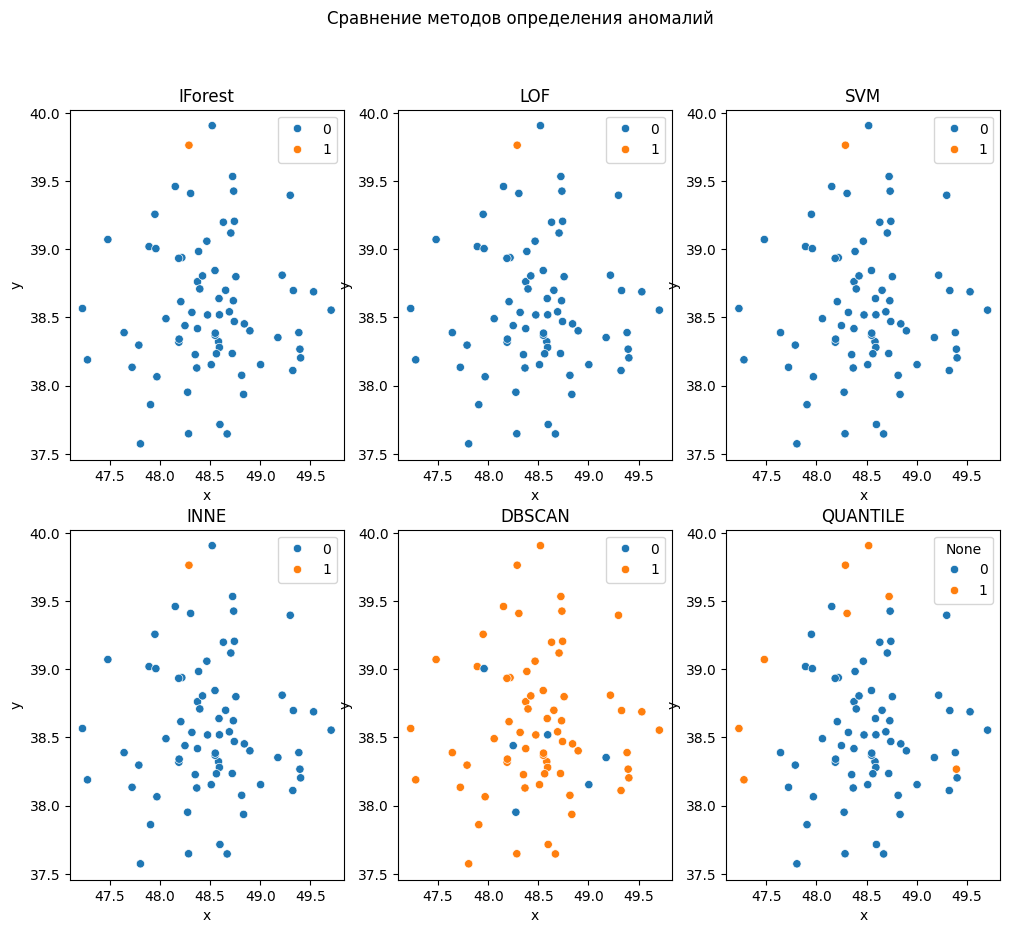

In [15]:
contamination = 0.01
min_p, max_p = 0.01, 0.95
min_samples = 4
eps = 0.04


class QuantileDetector:
    def __init__(self, min_p, max_p):
        self.min_p = min_p
        self.max_p = max_p

    def fit(self, X, col1, col2):
        self.min_x_th, self.max_x_th = X[col1].quantile([self.min_p, self.max_p])
        self.min_y_th, self.max_y_th = X[col2].quantile([self.min_p, self.max_p])

    def predict(self, X, col1, col2):
        return (
            (X[col1] < self.min_x_th)
            | (X[col1] > self.max_x_th)
            | (X[col2] < self.min_y_th)
            | (X[col2] > self.max_y_th)
        ).astype(np.int8)


clfs = (
    ("IForest", iforest.IForest(contamination=contamination, n_jobs=-1)),
    ("LOF", lof.LOF(contamination=contamination, n_jobs=-1)),
    ("SVM", ocsvm.OCSVM(contamination=contamination)),
    ("INNE", inne.INNE(contamination=contamination)),
    ("DBSCAN", DBSCAN(eps=eps, min_samples=min_samples)),
    ("QUANTILE", QuantileDetector(min_p, max_p)),
)
fig, ax = plt.subplots(2, 3, figsize=(12, 10))
e = 0
for i in range(2):
    for j in range(3):
        if e >= len(clfs):
            break

        clf = clfs[e][1]
        if clfs[e][0] == "QUANTILE":
            clf.fit(t[["dx", "dy"]], "dx", "dy")
            out = clf.predict(t[["dx", "dy"]], "dx", "dy")
        else:
            clf.fit(t[["dx", "dy"]].values)
            if clfs[e][0] == "DBSCAN":
                out = (clf.labels_ == -1).astype(np.int8)
            else:
                out = clf.predict(t[["dx", "dy"]].values)
        scale = t["x"] < 400
        sns.scatterplot(
            data=t[scale],
            x="x",
            y="y",
            hue=out[scale],
            ax=ax[i][j],
        ).set_title(clfs[e][0])
        e += 1
fig.suptitle("Сравнение методов определения аномалий")
plt.show()

P.S. Поскольку эти данные сгенерированы случайно, то, конечно, нельзя оценить качество алгоритмов. Все выводы сделаны на основании оригинальных данных, которых здесь нет.

Логично предположить, что в данном случае оптимальным алгоритмом является DBSCAN. Нужно только автоматизировать подбор параметров.

Text(0.5, 1.0, 'DBSCANDetector, eps=0.04, total out=1%')

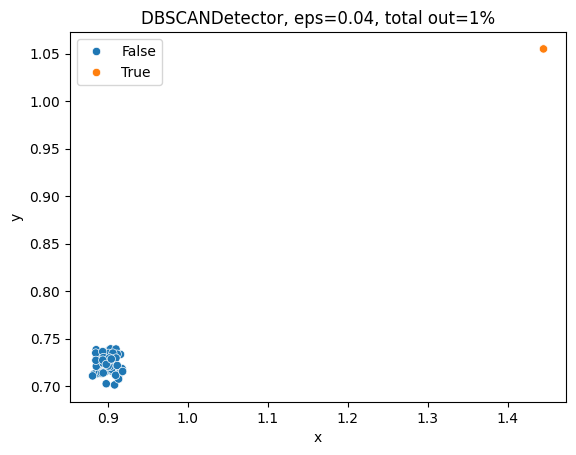

In [18]:
class DBSCANDetector:
    def __init__(self, data, min_samples):
        eps = self.compute_eps(data=data, n_neighbors=min_samples)
        self.clf = DBSCAN(eps=eps, metric="haversine", min_samples=min_samples)

    def compute_eps(self, data, n_neighbors, plot=False):
        neighbors = NearestNeighbors(n_neighbors=n_neighbors, metric="haversine")
        neighbors_fit = neighbors.fit(data)
        distances, _ = neighbors_fit.kneighbors(data)
        distances = np.sort(distances, axis=0)
        distances = distances[:, 1]
        if plot:
            plt.plot(distances)
        kneedle = KneeLocator(
            range(1, len(distances) + 1),
            distances,
            S=1.0,
            curve="convex",
            direction="increasing",
        )
        return kneedle.knee_y

    def predict(self, X):
        self.clf.fit(X)
        return self.clf.labels_ == -1


k = 10
t = df[df["object_id"] == k]
t = t.set_index("datetime")
t["x"] = np.deg2rad(t["x"])
t["y"] = np.deg2rad(t["y"])
t["dx"] = np.abs(t["x"] - t["x"].rolling("1d").median())
t["dy"] = np.abs(t["y"] - t["y"].rolling("1d").median())
t = t.reset_index()
min_samples = 4

clf = DBSCANDetector(data=t[["x", "y"]], min_samples=min_samples)
out = clf.predict(t[["dx", "dy"]])
scale = t["x"] < 100
sns.scatterplot(
    data=t[scale],
    x="x",
    y="y",
    hue=out[scale],
).set_title(
    f"{type(clf).__name__}, eps={round(eps, 3)}, total out={int(sum(out)/len(t)*100)}%"
)

In [21]:
def df_replace_outliers(args: list):
    """
    Заменяет аномальные значения.

    Аргументы:
    args = (k, freq).
    k : int - номер объекта.
    freq : str : шаг окна.
    """
    k, w = args
    dfd = df[df["object_id"] == k].copy()
    dfd = dfd.set_index("datetime")
    dfd["x"] = np.deg2rad(dfd["x"])
    dfd["y"] = np.deg2rad(dfd["y"])
    dfd["dx"] = np.abs(dfd["x"] - dfd["x"].rolling(w).median())
    dfd["dy"] = np.abs(dfd["y"] - dfd["y"].rolling(w).median())

    clf = DBSCANDetector(data=dfd[["x", "y"]], min_samples=4)
    out = clf.predict(dfd[["dx", "dy"]])

    dfd.loc[out, ["x", "y"]] = np.nan
    dfd["x"] = np.rad2deg(dfd["x"])
    dfd["y"] = np.rad2deg(dfd["y"])

    dfd["x"] = dfd["x"].interpolate("time", limit_direction="both")
    dfd["y"] = dfd["y"].interpolate("time", limit_direction="both")

    return dfd.drop(["dx", "dy"], axis=1)


# results = process_map(
#     df_replace_outliers,
#     [(k, "1d") for k in df["object_id"].unique()],
#     max_workers=mp.cpu_count(),
# )
# df = pd.concat(results)
# df = df.sort_values(by=["object_id", "datetime"]).reset_index()
df = df_replace_outliers_total(df, "1d")

100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


In [22]:
max_v = round(df["velocity"].quantile(0.99))
max_v

35

In [37]:
df = compute_velocity(df, "velocity_c")

Слишком высокие скорости отсечем и заменим путем интерполяции.

In [38]:
id = ((df["velocity"].isna()) | (df["velocity"] > max_v)) & (df["velocity_c"] <= max_v)
df.loc[id, "velocity"] = df.loc[id, "velocity_c"]
df["velocity"] = df["velocity"].interpolate()

In [25]:
df["target"].value_counts()

target
1.0    1198
0.0     235
Name: count, dtype: int64

# Dataset

In [43]:
df = (
    pd.read_csv("..\data\prepared_data\prepared_data.csv")
    .drop("Unnamed: 0", axis=1)
    .dropna()
)
df["datetime"] = pd.to_datetime(df["datetime"])
df.sample(5)

,datetime,object_id,x,y,velocity,target,velocity_c
969,2020-09-06 17:30:00,14.0,59.337351,49.470431,17.620,1.0,17.620232
1423,2020-09-20 17:30:00,20.0,41.324271,32.547482,11.250,1.0,82.373146
1255,2020-09-06 16:30:00,18.0,47.203129,37.215578,4.430,1.0,2.104598
50,2020-09-13 17:30:00,1.0,48.285238,37.646620,26.985,0.0,65.112187
1124,2020-09-13 16:45:00,16.0,53.895135,43.730190,20.350,1.0,84.316175


Отнормируем скорость.

In [44]:
df["velocity"] /= 100
df

,datetime,object_id,x,y,velocity,target,velocity_c
1,2020-08-16 16:45:00,1.0,48.583952,38.322338,0.27750,1.0,104.308272
2,2020-08-16 17:30:00,1.0,48.702429,38.984458,0.32560,0.0,36.325093
3,2020-08-16 17:45:00,1.0,48.741921,39.205165,0.23320,1.0,36.272185
4,2020-08-16 18:30:00,1.0,48.318417,38.536789,0.28560,0.0,49.094675
5,2020-08-16 18:45:00,1.0,48.896860,38.401796,0.18990,1.0,140.721433
...,...,...,...,...,...,...,...
1428,2020-09-20 19:45:00,20.0,41.901974,32.470521,0.12380,1.0,9.250222
1429,2020-09-20 20:30:00,20.0,41.559254,31.814743,0.35030,1.0,47.882839
1430,2020-09-20 20:45:00,20.0,41.445014,31.596150,0.14290,1.0,47.997133
1431,2020-09-20 21:30:00,20.0,40.929390,31.041989,0.19950,1.0,53.148342


Теперь основная идея - нужно собрать контекст перемещения объекта за последнее время, которое можно варьировать. Для удобство зададим следующие константы

In [45]:
HOUR = int(60 / 15)
DAY = HOUR * 24
BLOCK_SIZE = 6 * HOUR
HIDDEN_SIZE = 128
WINDOW_SIZE = 24 * DAY
INPUT_SIZE = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

У каждой точки есть контекст - движение за последнее BLOCK_SIZE время. Чтобы получить фичи из координат найдем вектор в направлении наибольшего удаления, построим ортогональный ему и перейдем к новому базису. Теперь координаты несут информацию о динамике движения объекта.

In [46]:
def distance(x: np.ndarray):
    """
    Рассчитывает расстояния от стартовой точки.
    """
    return np.sqrt(np.sum((x[0] - x) ** 2, axis=1))


def get_new_coords(coords: np.ndarray, basis: np.ndarray):
    """
    Формула перехода к новому базису.
    """
    A = np.linalg.inv(basis)
    return np.asarray([A @ v for v in (coords[0:] - coords[0])])


def get_path_pattern(x: np.ndarray):
    """
    Рассчитывает базис и возвращает координаты точек в нем.
    """
    max_d = np.argmax(distance(x))
    v1 = x[max_d] - x[0]
    if np.linalg.norm(v1) == 0:
        v1 = np.asarray([1, 0])
        v2 = np.asarray([0, 1])
    else:
        v1 /= np.linalg.norm(v1)
        v2 = np.asarray([-v1[1], v1[0]])
    basis = np.stack([v1, v2]).T
    pattern = get_new_coords(x, basis)
    return pattern

Приведем пример преобразования координат, отрисовав векторы базиса

Text(0.5, 1.0, 'Пример перехода к новому базису')

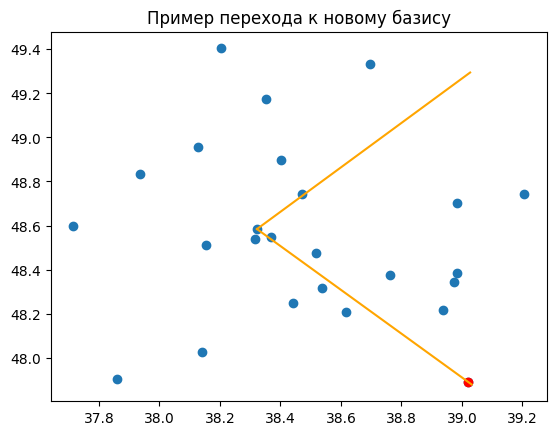

In [47]:
x = df[["y", "x"]].head(BLOCK_SIZE + 1).values
max_d = np.argmax(distance(x))
v1 = x[max_d] - x[0]
if np.linalg.norm(v1) == 0:
    v1 = np.asarray([1, 0])
    v2 = np.asarray([0, 1])
else:
    v1 /= np.linalg.norm(v1)
    v2 = np.asarray([-v1[1], v1[0]])
basis = np.stack([v1, v2]).T
pattern = get_new_coords(x, basis)
plt.scatter(x[:, 0], x[:, 1])
plt.scatter(x[max_d, 0], x[max_d, 1], color="red")
plt.plot([x[0, 0], x[0, 0] + v1[0]], [x[0, 1], x[0, 1] + v1[1]], color="orange")
plt.plot([x[0, 0], x[0, 0] + v2[0]], [x[0, 1], x[0, 1] + v2[1]], color="orange")
plt.title("Пример перехода к новому базису")

<b>Проблема с некоторыми объектами</b> - временной шаг больше 15 минут между наблюдениями, соответственно, не получается построить контекст.

In [49]:
def to_context(X: np.ndarray, y: np.ndarray, **kwargs):
    """
    Рассчитывает паттерн движения. Для этого объединяет наблюдения в группы
    фиксированного размера и с одинаковыми временными метками, если это возможно.

    Далее рассчитывает наибольшее отклонение от начальной точки - это направление
    выбирается в качестве одного вектора в новом базисе. Второй получается автоматически.
    Начальные точки переводятся в новый базис.
    """
    if X.shape[0] <= BLOCK_SIZE:
        warnings.warn(
            f"Too few samples. Length of X is {X.shape[0]}, BLOCK_SIZE = {BLOCK_SIZE}, object_id = {kwargs['object_id']:0.0f}"
        )
        return np.array([]), np.array([])
    seqs = np.zeros((X.shape[0] - BLOCK_SIZE, BLOCK_SIZE + 1, INPUT_SIZE))
    targets = np.empty(X.shape[0] - BLOCK_SIZE)
    k = 0
    i = 1
    while i < X.shape[0] - BLOCK_SIZE:
        end_idx = i + BLOCK_SIZE + 1
        if end_idx >= X.shape[0]:
            break
        checker = np.argwhere(
            np.diff(X[i:end_idx, 0])
            > pd.to_timedelta(kwargs["freq"], unit="min")
            + pd.to_timedelta(np.log10(kwargs["freq"]), unit="min")
        )
        if checker.size == 0:
            slc = X[i:end_idx, 1:].astype(np.float32)
            new_coords = get_path_pattern(slc[:, :2])
            seqs[k] = np.hstack([new_coords, slc[:, 2:]])
            targets[k] = y[end_idx - 1]
            k += 1
            i += 1
        else:
            i += checker[-1, 0] + 1
    if k == 0:
        warnings.warn(
            f"Can't construct contexts for given freq. object_id = {kwargs['object_id']:0.0f}, freq = {kwargs['freq']}."
        )
    return seqs[:k], targets[:k]


def train_test_split(args):
    """
    Разделяет данные на обучающую, валидационную, калибрационную и тестовую выборки.
    args : list = (df, object_id, freq)
    df : pd.DataFrame - данные по одному объекту.
    object_id - номер объекта.
    freq - временной шаг сбора контекста.
    """
    df, object_id, freq = args
    X, y = (
        df[["datetime", "y", "x", "velocity"]].values,
        df["target"].values,
    )
    X, y = to_context(X, y, object_id=object_id, freq=freq)
    X_train, X_calib, X_val, X_test = np.split(
        X, [int(0.65 * len(X)), int(0.7 * len(X)), int(0.8 * len(X))]
    )
    y_train, y_calib, y_val, y_test = np.split(
        y, [int(0.65 * len(y)), int(0.7 * len(y)), int(0.8 * len(y))]
    )
    return X_train, y_train, X_calib, y_calib, X_val, y_val, X_test, y_test


# results = process_map(
#     train_test_split,
#     [(df[df.object_id == k], k, 15) for k in df["object_id"].unique()],
#     max_workers=mp.cpu_count(),
# )

Соберем данные по масивам. При этом данные для обучения расположены во времени раньше, чем тестовые, то есть утечки информации тут нет.

In [46]:
X_train, y_train = np.concatenate(
    [r[0] for r in results if len(r[0].shape) == 3]
), np.concatenate([r[1] for r in results])
X_calib, y_calib = np.concatenate(
    [r[2] for r in results if len(r[2].shape) == 3]
), np.concatenate([r[3] for r in results])
X_val, y_val = np.concatenate(
    [r[4] for r in results if len(r[4].shape) == 3]
), np.concatenate([r[5] for r in results])
X_test, y_test = np.concatenate(
    [r[6] for r in results if len(r[6].shape) == 3]
), np.concatenate([r[7] for r in results])

Проверим баланс классов, а также распределения на разных частях данных.

In [47]:
np.unique(y_train, return_counts=True), np.unique(y_calib, return_counts=True), np.unique(
    y_val, return_counts=True
), np.unique(y_test, return_counts=True)

((array([0., 1.]), array([ 82588, 108027])),
 (array([0., 1.]), array([6141, 8517])),
 (array([0., 1.]), array([15337, 14008])),
 (array([0., 1.]), array([29075, 29611])))

Видим, что обучать и тестировать модель будем примерно на одном распределении, то есть наши оценки будут достоверными.

Приведем данные в Torch формат

In [48]:
class Data(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X, self.y = torch.as_tensor(X, dtype=torch.float32), torch.as_tensor(
            y, dtype=torch.y
        )

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx: int):
        return self.X[idx], self.y[idx]

In [49]:
BATCH_SIZE = 1024

train_data = Data(X_train, y_train)
calib_data = Data(X_calib, y_calib)
val_data = Data(X_val, y_val)
test_data = Data(X_test, y_test)

train_loader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, drop_last=True
)
calib_loader = DataLoader(
    calib_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, drop_last=True
)
val_loader = DataLoader(
    val_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, drop_last=True
)
test_loader = DataLoader(
    test_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, drop_last=True
)

# Model

Классическая реализация классификатора на базе LSTM, есть возможность задавать dropout, количество слоев, размерность внутреннего пространства и входных данных (если в будущем добавим фичи) 

In [50]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropouts=[0, 0]):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            dropout=dropouts[0],
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn = nn.BatchNorm1d(hidden_size // 2)
        self.relu = nn.ReLU()
        self.dp = nn.Dropout(p=dropouts[1])
        self.fc2 = nn.Linear(hidden_size // 2, 2)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)

        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)

        x, _ = self.lstm(x, (h_0, c_0))
        x = x[:, -1]
        x = self.fc1(x)
        x = self.bn(x)
        x = self.dp(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

Реализация GRU - сравнима по качеству с LSTM, но имеет меньше параметров

In [51]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropouts=[0, 0]):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            dropout=dropouts[0],
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn = nn.BatchNorm1d(hidden_size // 2)
        self.relu = nn.ReLU()
        self.dp = nn.Dropout(p=dropouts[1])
        self.fc2 = nn.Linear(hidden_size // 2, 2)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)

        x, _ = self.gru(x, h_0)
        x = x[:, -1]
        x = self.fc1(x)
        x = self.bn(x)
        x = self.dp(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

Так как модели возвращают логиты, для дальнейшего анализа их нужно перевести в вероятности.

In [52]:
def to_prob(logits: np.ndarray):
    return F.softmax(torch.Tensor(logits), dim=1).numpy()

## Training

Вспомогательные функции для обучения и оценки модели.

In [53]:
def get_outputs_and_targets(model: nn.Module, loader: DataLoader):
    """
    Возвращает предсказания (логиты) по данным.
    """
    model.eval()
    outputs = np.empty((len(loader) * BATCH_SIZE, 2))
    targets = np.empty(len(loader) * BATCH_SIZE)
    start = 0
    end = BATCH_SIZE
    seed_everything(42)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            logits = model(x)
            outputs[start:end] = logits.cpu().numpy()
            targets[start:end] = y.numpy()
            start += BATCH_SIZE
            end += BATCH_SIZE
    return outputs, targets.astype(np.int8)


def eval_metrics(
    model: nn.Module, val_loader: DataLoader, metrics: list, device: str = "cuda:0"
):
    """
    Возвращает оценку модели по заданным метрикам.
    """
    seed_everything(42)
    model.eval()
    scores = {}
    val_outputs, val_targets = get_outputs_and_targets(model, val_loader)
    val_outputs = F.softmax(torch.Tensor(val_outputs), dim=1).argmax(dim=1).numpy()
    for metric in metrics:
        scores[metric.__name__] = metric(val_outputs, val_targets)
    return scores


def eval_loss(
    model: nn.Module, val_loader: DataLoader, criterion, device: str = "cuda:0"
):
    """
    Возвращает значение loss фунции на данных.
    """
    losses = []
    seed_everything(42)
    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y).item()
            losses.append(loss)
    return np.mean(losses)

Сам скрипт обучения. Все стандартно, дополнительно используем scheduler и grad clipping для лучшей сходимости и борьбы со взрывающимся градиентом. Также используем класс scaler - динамически производящий вычисления в fp16 режиме, если это возможно. Это значительно ускоряет обучение, не сильно сказываясь на качестве обучения. 

In [54]:
scaler = torch.cuda.amp.GradScaler()


def train(
    model: nn.Module,
    train_loader: DataLoader,
    optimizer,
    criterion,
    scheduler=None,
    warmup_scheduler=None,
    epochs: int = 10,
    val_loader: DataLoader = None,
    compute_val_loss: bool = True,
    compute_metrics: bool = True,
    metrics: list = None,
    verbose: bool = True,
    checkpoint_path: str = "./",
    checkpoint_step: int = 10,
    device: str = "cuda:0",
    wb=False,
):
    train_history, val_history = [], []
    if compute_val_loss:
        class_weights = class_weight.compute_class_weight(
            "balanced", classes=np.array([0, 1]), y=val_loader.dataset.y.numpy()
        )
        weights = torch.tensor(class_weights, dtype=torch.float32)
        val_criterion = nn.CrossEntropyLoss(weight=weights).to(DEVICE)

    for epoch in range(1, epochs + 1):
        model.train()
        loop = tqdm(train_loader, desc="Training", position=0, leave=True)
        epoch_history = 0

        if epoch % checkpoint_step == 0:
            torch.save(model.state_dict(), checkpoint_path + str(epoch) + ".pt")

        for x, y in loop:
            model.zero_grad(set_to_none=True)
            x = x.to(device)
            y = y.to(device)
            with torch.autocast(device_type=device, dtype=torch.float16):
                outputs = model(x)
                if type(criterion).__name__ == "FocalLoss":
                    outputs = F.softmax(outputs, dim=1)
                loss = criterion(outputs, y)

            epoch_history += loss.item()

            if verbose:
                loop.set_description(f"Epoch {epoch} | Loss: {loss.item():.4f}")

            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(), 10)
            scaler.step(optimizer)
            scaler.update()

            if scheduler is not None:
                with warmup_scheduler.dampening():
                    scheduler.step()

        if compute_val_loss:
            val_loss = eval_loss(model, val_loader, val_criterion)
            if not wb and verbose:
                tqdm.write(f"Val loss: {val_loss:.4f}")
            val_history.append(val_loss)

        if compute_metrics:
            scores = eval_metrics(model, val_loader, metrics)
            if not wb and verbose:
                s = ""
                for metric in metrics:
                    s += f"{metric.__name__}: {scores[metric.__name__]:.4f} "
                tqdm.write(s)
        train_history.append(epoch_history / len(train_loader))
        if wb:
            scores["train_loss"] = epoch_history / len(train_loader)
            scores["val_loss"] = val_loss
            wandb.log(scores)

    return train_history, val_history

Рассчитаем веса классов, что поможет функции ошибки более точно направлять модель при обучении.

In [55]:
class_weights = class_weight.compute_class_weight(
    "balanced", classes=np.array([0, 1]), y=train_loader.dataset.y.numpy()
)
weights = torch.tensor(class_weights, dtype=torch.float32)
weights

tensor([1.1540, 0.8823])

Зададим метрики, которые будем отслеживать. 

Matthews - метрика со значениями [0, 1], где 0 - случайное предсказание, 1 - идеальное. В отличие от F1, Recall, Precision - учитывает все клетки матрицы ошибки классификации, то есть в рассчете участвуют все TP, FP, TN, FN, это дает более точную оценку качеству модели.

In [56]:
f1 = lambda pred, y: f1_score(y, pred, zero_division=0.0)
f1.__name__ = "f1_score"

matthews = lambda pred, y: matthews_corrcoef(y, pred)
matthews.__name__ = "matthews_corr"

Инициализируем weights & biases - сервис логирования экспериментов.

In [ ]:
params = {
    "hidden_size": 128,
    "num_layers": 2,
    "learning_rate": 1e-3,
    "dropout": [0.6, 0.6],
    "epochs": 100,
}
wandb.init(
    project="project",
    config={
        "optimizer": "AdamW",
        "criterion": "FocalLoss",
        "learning_rate": params["learning_rate"],
        "architecture": f'GRU, hidden={params["hidden_size"]}, layers={params["num_layers"]}, dropout={params["dropout"]}',
        "epochs": params["epochs"],
    },
)

Запускаем обучение

In [ ]:
model = GRU(
    input_size=INPUT_SIZE,
    hidden_size=params["hidden_size"],
    num_layers=params["num_layers"],
    dropouts=params["dropout"],
).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=params["learning_rate"])
num_steps = len(train_loader) * 80
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps)
warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)
# criterion = nn.CrossEntropyLoss(weights).to(DEVICE)
criterion = FocalLoss(gamma=2, weights=weights.to(DEVICE), reduction="mean").to(DEVICE)
train_history, val_history = train(
    model,
    train_loader,
    optimizer,
    criterion,
    scheduler=lr_scheduler,
    warmup_scheduler=warmup_scheduler,
    epochs=params["epochs"],
    val_loader=val_loader,
    compute_val_loss=True,
    compute_metrics=True,
    metrics=(accuracy_score, f1, matthews),
    device=DEVICE,
    verbose=True,
    checkpoint_path="./checkpoint/",
    checkpoint_step=1000,
    wb=True,
)
# wandb.finish()

Epoch 1 | Loss: 0.2225: 100%|██████████| 186/186 [00:02<00:00, 90.33it/s] 
Epoch 2 | Loss: 0.1547: 100%|██████████| 186/186 [00:02<00:00, 88.72it/s] 
Epoch 3 | Loss: 0.1383: 100%|██████████| 186/186 [00:01<00:00, 98.70it/s] 
Epoch 4 | Loss: 0.1349: 100%|██████████| 186/186 [00:01<00:00, 98.75it/s] 
Epoch 5 | Loss: 0.1333: 100%|██████████| 186/186 [00:01<00:00, 98.39it/s] 
Epoch 6 | Loss: 0.1335: 100%|██████████| 186/186 [00:01<00:00, 97.21it/s] 
Epoch 7 | Loss: 0.1323: 100%|██████████| 186/186 [00:02<00:00, 89.27it/s] 
Epoch 8 | Loss: 0.1301: 100%|██████████| 186/186 [00:01<00:00, 97.14it/s] 
Epoch 9 | Loss: 0.1288: 100%|██████████| 186/186 [00:01<00:00, 98.53it/s] 
Epoch 10 | Loss: 0.1269: 100%|██████████| 186/186 [00:02<00:00, 89.84it/s] 
Epoch 11 | Loss: 0.1255: 100%|██████████| 186/186 [00:01<00:00, 99.05it/s] 
Epoch 12 | Loss: 0.1242: 100%|██████████| 186/186 [00:01<00:00, 97.81it/s] 
Epoch 13 | Loss: 0.1238: 100%|██████████| 186/186 [00:02<00:00, 89.65it/s] 
Epoch 14 | Loss: 0.12

In [26]:
torch.save(model.state_dict(), "gru_trained.pt")

Теперь оценим качество на валидации.

In [28]:
val_outputs, val_targets = get_outputs_and_targets(model, val_loader)

In [29]:
print(
    classification_report(val_targets, to_prob(val_outputs).argmax(1)),
    "\n",
    matthews_corrcoef(val_targets, to_prob(val_outputs).argmax(1)),
)

              precision    recall  f1-score   support

           0       0.73      0.83      0.78     14990
           1       0.79      0.67      0.72     13682

    accuracy                           0.75     28672
   macro avg       0.76      0.75      0.75     28672
weighted avg       0.76      0.75      0.75     28672
 
 0.5083157627649317


В целом модель научилась различать классы, хотя отдает приоритет 0 классу.

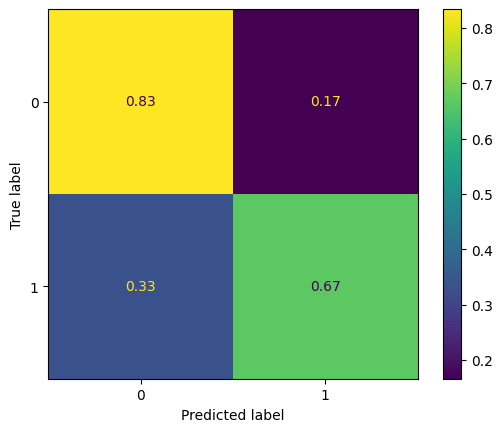

In [30]:
ConfusionMatrixDisplay(
    confusion_matrix(val_targets, to_prob(val_outputs).argmax(1), normalize="true")
).plot()

Вероятности распределены вокруг 0.5, модель не очень уверена в своих ответах

[Text(0.5, 1.0, 'Softmax outputs for class 1')]

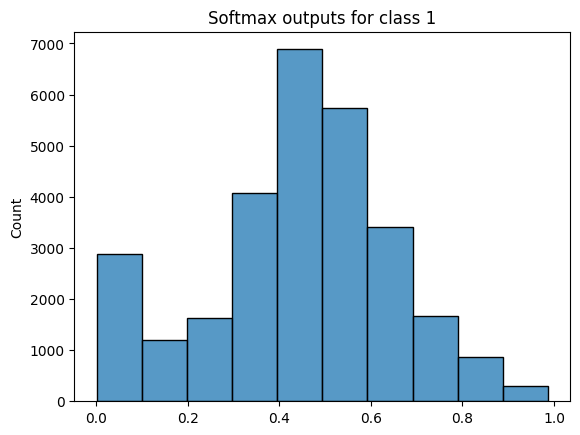

In [31]:
sns.histplot(to_prob(val_outputs)[:, 1], bins=10).set(title="Softmax outputs for class 1")

# Calibration

С помощью калибровки, можно улучшить вероятностные оценки модели.

In [32]:
calib_outputs, calib_targets = get_outputs_and_targets(model, calib_loader)

In [33]:
calib_model = OutputCalibClassifier()
status = calib_model.calibrate(
    calib_outputs=calib_outputs,
    calib_targets=calib_targets,
    config=Config(optimizer=Optimizer(n_epochs=1000)),
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
Epoch: 1000 | loss: 0.14851: 100%|██████████| 1000/1000 [00:01<00:00, 848.85it/s]


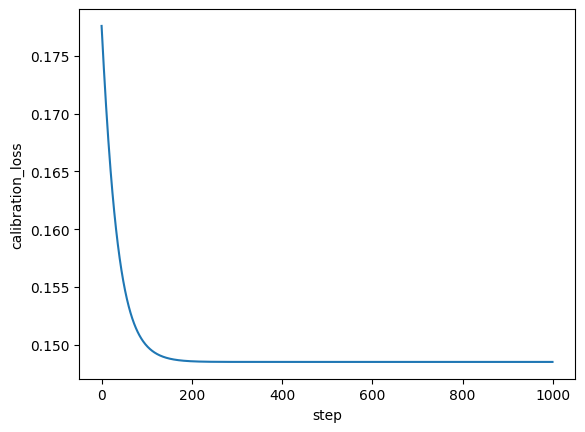

In [34]:
fig, ax = plt.subplots()
ax.set_xlabel("step")
ax.set_ylabel("calibration_loss")
ax.plot(status["loss"])
plt.show()

# Conformal Predictions

Согласно алгоритму, нужно использовать дополнительную выборку для построения конформных наборов (val).

In [35]:
val_outputs, val_targets = get_outputs_and_targets(model, val_loader)
test_outputs, test_targets = get_outputs_and_targets(model, test_loader)

In [36]:
test_modes_calibrated = calib_model.predictive.mode(outputs=test_outputs)
test_means_calibrated = calib_model.predictive.mean(outputs=test_outputs)
val_means_calibrated = calib_model.predictive.mean(outputs=val_outputs)

Сравним откалиброванную модель и исходную.

[Text(0.5, 1.0, 'After calibration')]

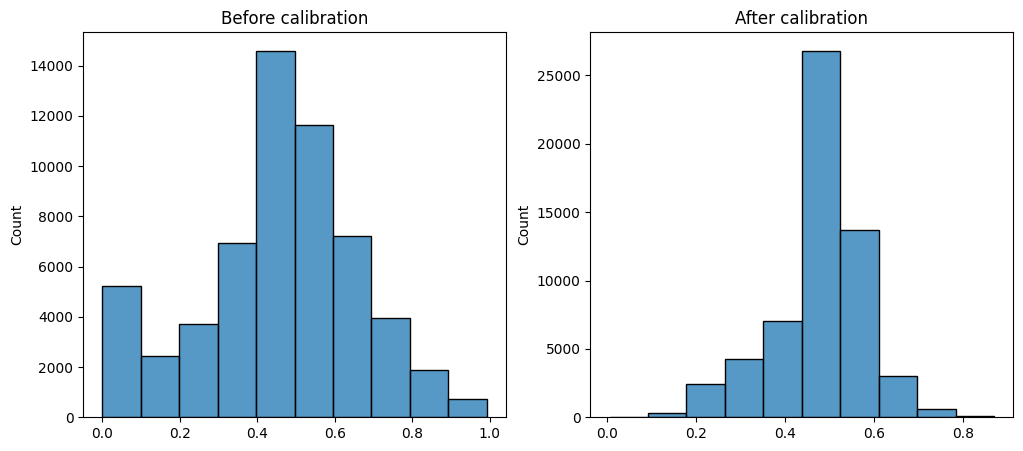

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(to_prob(test_outputs)[:, 1], ax=ax[0], bins=10).set(
    title="Before calibration"
)
sns.histplot(test_means_calibrated[:, 1], ax=ax[1], bins=10).set(
    title="After calibration"
)

In [38]:
conformal_sets = AdaptivePredictionConformalClassifier().conformal_set(
    val_probs=val_means_calibrated,
    test_probs=test_means_calibrated,
    val_targets=val_targets,
    error=0.1,
)

In [39]:
sizes = [len(s) for s in np.array(conformal_sets, dtype="object")]
set_sizes, sizes_counts = np.unique(sizes, return_counts=True)
avg_size = np.mean(sizes)
max_size = np.max(sizes)
min_size = np.min(sizes)
mode_size = set_sizes[np.argmax(sizes_counts)]

avg_size_wellclassified = np.mean(
    [
        len(s)
        for s in np.array(conformal_sets, dtype="object")[
            test_modes_calibrated == test_targets
        ]
    ]
)
avg_size_misclassified = np.mean(
    [
        len(s)
        for s in np.array(conformal_sets, dtype="object")[
            test_modes_calibrated != test_targets
        ]
    ]
)

print(
    f"Average conformal set size: {avg_size}\nMax conformal set size: {max_size}\n"
    f"Min conformal set size: {min_size}\nMode conformal set size: {mode_size}"
)

print(f"Average conformal set size over well classified input: {avg_size_wellclassified}")
print(f"Average conformal set size over misclassified input: {avg_size_misclassified}")

Average conformal set size: 1.7977830317982457
Max conformal set size: 2
Min conformal set size: 1
Mode conformal set size: 2
Average conformal set size over well classified input: 1.864212602122265
Average conformal set size over misclassified input: 1.6183743342632513


[]

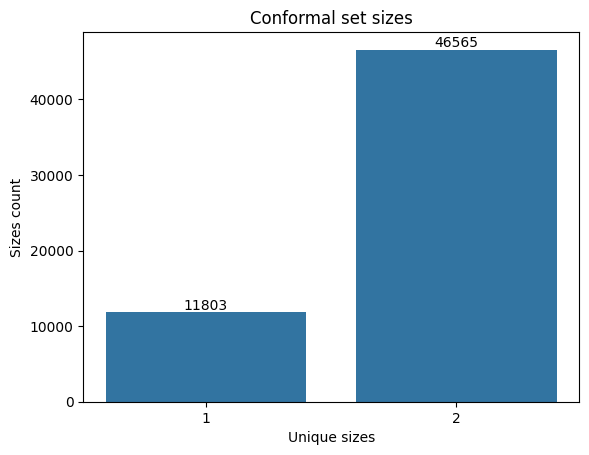

In [40]:
ax = sns.barplot(x=set_sizes, y=sizes_counts)
ax.set(xlabel="Unique sizes", ylabel="Sizes count", title="Conformal set sizes")
ax.bar_label(ax.containers[0], fmt="%d")
ax.plot()

Набор размера 2 означает, что модель с вероятностью почти 0.1 ошибается в выборе класса. 

Набор размера 1 - что модель точно уверена в ответе.

# Reliability plot

Для оценки уверенности также построим кривые надежности.

In [41]:
def get_calibration_curve(probs, targets, label, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    probs = probs[:, label]
    x = []
    y = []
    for i in range(n_bins - 1):
        lower = bins[i]
        upper = bins[i + 1]
        inds = np.where((probs >= lower) & (probs <= upper))
        if inds[0].shape[0] > 0:
            true_pred = (targets[inds] == label).sum()
            bin_conf = np.mean(probs[inds]).item()
            bin_accuracy = (true_pred / inds[0].shape[0]).item()
        else:
            bin_conf = (lower + upper) / 2
            bin_accuracy = bin_conf
        x.append(bin_conf)
        y.append(bin_accuracy)
    return x, y


def plot_calibration_curve(means, targets, label, n_bins=10, ax=None):
    x, y = get_calibration_curve(means, targets, label, n_bins=n_bins)
    if ax is None:
        _, ax = plt.subplots()
    sns.lineplot(x=x, y=y, color="#E66787", ax=ax, label="model")
    sns.lineplot(
        x=[0, 1],
        y=[0, 1],
        color="black",
        linestyle="--",
        ax=ax,
        label="perfectly calibrated",
    )
    sns.scatterplot(x=x, y=y, marker="o", color="#E66787", ax=ax)
    ax.set(
        xlabel="Confidence",
        ylabel="Accuracy",
        title=f"Reliability plot for {label} label",
    )
    plt.setp(ax.lines, zorder=0)
    sns.move_legend(ax, "lower right")

    ax.plot()

График интерпретировать так: если ответы модели (выделены розовым) ниже черной прямой, это говорит о чрезмерной уверенности модели в своих ответах, если выше, то наоборот - о недостаточной уверенности. График ниже соответствует типовой картине для нейронных сетей - часто они не так просто поддаются калибровке

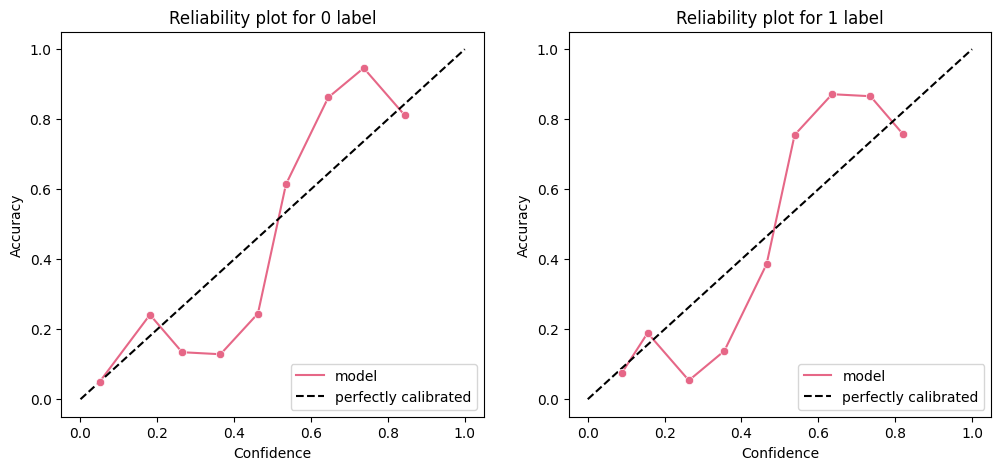

In [42]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2, nrows=1)
plot_calibration_curve(test_means_calibrated, test_targets, 0, ax=ax[0])
plot_calibration_curve(test_means_calibrated, test_targets, 1, ax=ax[1])
plt.show()